# Nonlinear analysis -Assignment 2

03.10.2023 - Laure Toullier and Jérémie Engler

## Exercice 1

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Definitions

In [2]:
# Element connectivity
nelements = 2 
nnodes = 3

# Written input:
connectivity = np.array([[1, 2], [2, 3]])
nodes_P = np.array([2])

# Unit stiffness matrix of bar in local coordinate system
K_unit = np.array([[1, 0, -1, 0], 
                   [0, 0,  0, 0], 
                   [-1, 0, 1, 0], 
                   [0, 0, 0, 0]])
NDOF = 2*len(nodes_P)

# Input data and element stiffness matrices
E = [200e3,200e3]  # N/mm^2 Young modulus of the elements
A = [15e3,2e3] #mm^2 Cross-sectional area of the elements
a = 3000 #mm Half lenght of the truss
b = 4000 #mm Height of the truss
P = 10000e3 #7862e3 #N Load
phiP = 60 #° Angle of load
theta = [53.13, -53.13] #° Angle of elements, at first node of the element
Pglob = np.array([P*np.cos(np.radians(phiP)), P*np.sin(np.radians(phiP))]) #N P force in global coordinates (x,y)
alpha = 0.02
sigmay = 500 #Mpa

#Variables and tracking vectors initialization

plastifiedelem = [] #Track which elements are plastified
Pcp = []
lambdatemp = []
alphaelem = [1,1]
Ucp = np.zeros((nelements,2,1))
Pglobit = Pglob

#Initialisation of the plotted vectors

u = [0]
v = [0]
px = [0]
py = [0]
p = [0]

print(Pglob)

[5000000.         8660254.03784439]


Functions definitions

In [3]:
def constitutive_law_force(T,L,i,u):
    P = E[i] * A[i] * u[i]
    return P

def constitutive_law_stiffness(T,L,i,u):
    ki = E[i] * A[i] / L[i]
    return ki

def lengths_rotmat_and_Fy():

    #Length of elements, rotation matrices and yielding forces

    T = np.zeros((nelements,4,4))
    L = []
    Fy = []

    for i in range(nelements):
        c = np.cos(np.radians(theta[i]))
        s = np.sin(np.radians(theta[i]))
        Li = abs(a/c)
        if theta[i] == -90:
            Li = b
        T[i] = np.array([[c, s, 0, 0], 
                [-s, c, 0, 0], 
                [0, 0, c, s], 
                [0, 0, -s, c]])
        L.append(Li)
        Fyi = sigmay * A[i]
        Fy.append(Fyi)

    return L,T,Fy

def u_y(sigmay, L, E):
    uy = []
    for i in range(nelements):
        uy.append(sigmay * L[i] / E[i])
    return uy
    
def stiffness_matrices(T,L):

    k = []
    k_glob = np.zeros((nelements,4,4))

    #Stiffness matrices

    for i in range(nelements):
        ki = constitutive_law_stiffness(T,L,i,0)
        k.append(ki)
        k_glob[i] = ki * T[i].T @ K_unit @ T[i]
    
    return k,k_glob

def assemble(alphaelem, k_glob):
    # Assemble global stiffness matrix
    NDoF = 2*nnodes
    K_global = np.zeros((NDoF,NDoF))
    K_globals = np.zeros((nelements,NDoF, NDoF))
# Assemble elements
    for i in range (nelements):
        connectelem = connectivity[i] #nodes connected to the element
        indexs = 2*connectelem
        i11 = indexs[0]-2
        i12 = indexs[0]
        i21 = indexs[1]-2
        i22 = indexs[1]

        Ki_global = np.zeros((NDoF, NDoF))
        ki_global = alphaelem[i]*k_glob[i]
        Ki_global[i11:i12, i11:i12] = ki_global[0:2, 0:2]
        Ki_global[i21:i22, i11:i12] = ki_global[2:4, 0:2]
        Ki_global[i11:i12, i21:i22] = ki_global[0:2, 2:4]
        Ki_global[i21:i22, i21:i22] = ki_global[2:4, 2:4]
        # print(f"Ki_global = {Ki_global}")
        K_global = K_global + Ki_global
        K_globals[i] = Ki_global

    return(K_global,K_globals)

def u_vec_and_F(P,K_global):
    # Calculate displacements at nodes with forces applied
    numnodesP = len(nodes_P)
    F_red = P
    # print(f"Applied force at iteration {len(plastifiedelem)} = {F_red}")
    indexssup = 2*nodes_P - 1
    indexsinf = indexssup - 1
    mask = []
    for i in range(numnodesP):
        mask.append(indexsinf[i])
        mask.append(indexssup[i])
    K_red = K_global[mask,:]
    K_red = K_red[:,mask]

    # print(f"K_red = {K_red}")

    u_red = np.linalg.inv(K_red) @ F_red

    # print(u_red)
    # print(f"Displacement at iteration {len(plastifiedelem)} = {u_red}")

    # Calculate reaction forces at other nodes
    u_vec = np.zeros((2*nnodes))

    for i in range(numnodesP):
        u_vec[indexsinf[i]] = u_red[2*i]
        u_vec[indexssup[i]] = u_red[2*i+1]

    F = K_global @ u_vec

    return(u_vec,F)

def axialforces(K_globals,u_vec,T):
    axialF = []
    for i in range(nelements):
        F_elei = K_globals[i] @ u_vec
        index_red = 2*connectivity[i]
        F_elei_red = F_elei[[index_red[0]-2, index_red[0]-1, index_red[1]-2, index_red[1]-1]]
        F_elei_local = T[i] @ F_elei_red
        Fi = F_elei_local[2]
        print(f"Fi = {Fi}")
        axialF.append(Fi)

    return(axialF)

def axialforces_withload(P,T): #UNSTABLE - NOT WORKING
    axialF = []
    for i in range(nelements):
        F_elei_red = P
        F_elei_local = T[i] @ F_elei_red
        Fi = F_elei_local[2]
        print(f"Fi = {Fi}")
        axialF.append(Fi)

    return(axialF)


def printgraph(x,y,xname,yname,unit1, unit2):
    plt.plot(x,y,'o')
    plt.plot(x,y,'b')

    plt.title(f'{yname} as a function of {xname}')
    plt.xlabel(f"{xname} ({unit1})")
    plt.ylabel(f"{yname} ({unit2})")

    plt.show()

    return None

def points_archives(u,v,px,py,p):

    for i in nodes_P:
        j = i-1
        u.append(u_vec[2*j]+u[-1])
        v.append(u_vec[2*j+1]+v[-1])
        px.append(F[2*j]+px[-1])
        py.append(F[2*j+1]+py[-1])
        p.append(F[2*j]/np.cos(phiP)+p[-1])
    return u,v,px,py,p



Initial stiffness and event to event analysis

In [4]:
L,T,Fy = lengths_rotmat_and_Fy()

print(Fy)

k,k_glob = stiffness_matrices(T,L)

#Event to event analysis

while len(plastifiedelem) < nelements: 
    lambdait = 1

    #Calculate P from last iterations
    Plastit = [0,0]
    for i in range(len(Pcp)):
        Plastit += Pcp[i] 
    
    #Assemble elementes

    K_global,K_globals = assemble(alphaelem, k_glob)
    
    #System equilibrium with incremental load
    
    u_vec,F = u_vec_and_F(Pglob,K_global)

    # Calculate axial forces

    axialF = axialforces(K_globals,u_vec,T)

    print(f"axialF = {axialF}")

    pelemindex = -1
    for i in range(nelements):
        if abs(axialF[i]) > Fy[i] and abs(Fy[i]/axialF[i]) < lambdait and Fy[i] != 0:
            # plastifiedelem.append(i)
            if len(plastifiedelem) != 0:
                lambdait = abs((Fy[i]-abs(axialFprev[i]))/axialF[i])
            else:
                lambdait = abs((Fy[i])/axialF[i])
            print(f"Element {i}, lambda = {lambdait}")
            pelemindex = i
            Fy[i] = 0
    
    if pelemindex != -1:
        plastifiedelem.append(pelemindex)
        lambdatemp.append(lambdait)
        alphaelem[pelemindex] = alpha

    # print(plastifiedelem)
    # print(f"lambdas = {lambdatemp}")

    Pcpi = lambdait * Pglobit
    print(f"Pcpi = {Pcpi}")
    Pcp.append(Pcpi)


    #System equilibrium with plastification load for iteration

    Plastit = [0,0]
    if len(Pcp) > 0:
        for i in range(len(Pcp)):
            Plastit = Pcp[-1] 


    print("Plstit = ",Plastit)

    u_vec,F = u_vec_and_F(Plastit,K_global)

    print(u_vec)

    # Calculate axial forces with plasitification load

    axialFprev = axialforces(K_globals,u_vec,T)
    
    u,v,px,py,p = points_archives(u,v,px,py,p)

    print("New iteration", "\n")

# Final slope

final_load = Pcp[-1]*2 # Relevant load step in order to observe the behavior after plastification of the entire truss
print(final_load)

K_global,K_globals = assemble(alphaelem, k_glob)

#System equilibrium with final load

u_vec,F = u_vec_and_F(final_load,K_global)

u,v,px,py,p = points_archives(u,v,px,py,p)

displacementpoints = []
for i in range(len(plastifiedelem)+2):
    displacementpoints.append([u[i],v[i]])

print(f"Displacements for every events [u,v]: {displacementpoints}")
    
    

[7500000.0, 1000000.0]
Fi = 9579322.76777836
Fi = 1246009.283462504
axialF = [9579322.76777836, 1246009.283462504]
Element 0, lambda = 0.7829363496579835
Pcpi = [3914681.74828992 6780427.6835007 ]
Plstit =  [3914681.74828992 6780427.6835007 ]
[ 0.          0.          0.25472837 15.43393673  0.          0.        ]
Fi = 7500000.0
Fi = 975545.9600340928
New iteration 

Fi = 9579322.767778357
Fi = 1246009.283462504
axialF = [9579322.767778357, 1246009.283462504]
Element 1, lambda = 0.01962588906075604
Pcpi = [ 98129.44530378 169965.1849847 ]
Plstit =  [ 98129.44530378 169965.1849847 ]
[ 0.          0.         12.80095429  9.98284543  0.          0.        ]
Fi = 188002.72591759256
Fi = 24454.03996590733
New iteration 

[196258.89060756 339930.3699694 ]
Displacements for every events [u,v]: [[0, 0], [0.25472836950797983, 15.433936729520582], [13.055682660972561, 25.416782155469633], [13.694211032119792, 64.10507784599663]]


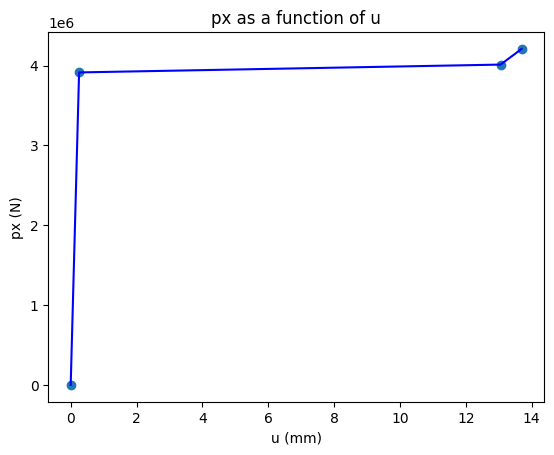

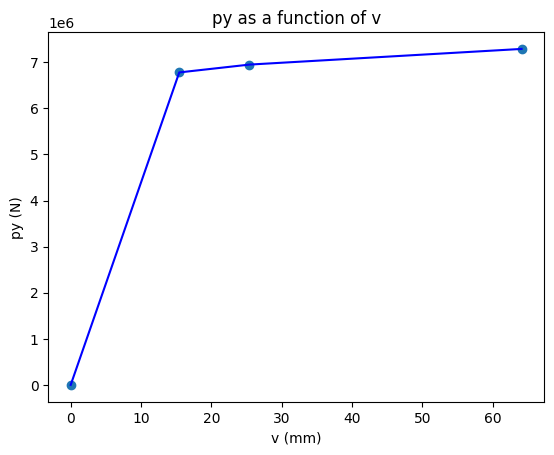

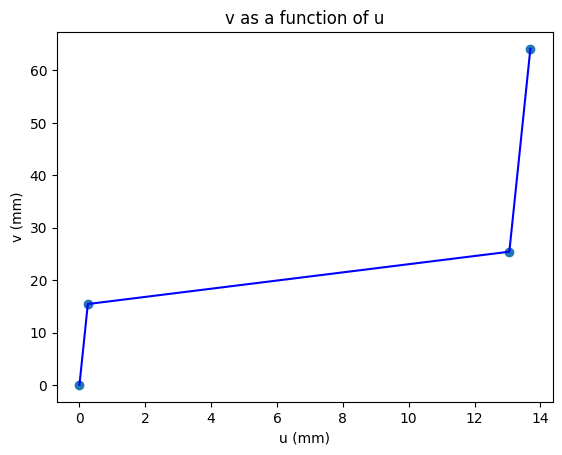

In [5]:
printgraph(u,px,"u","px","mm","N")
printgraph(v,py,"v","py","mm","N")
printgraph(u,v,"u","v","mm","mm")

## Part c)

Definitions

In [39]:
# Element connectivity
nelements = 2 
nnodes = 3

# Written input:
connectivity = np.array([[1, 2], [2, 3]])
nodes_P = np.array([2])

# Unit stiffness matrix of bar in local coordinate system
K_unit = np.array([[1, 0, -1, 0], 
                   [0, 0,  0, 0], 
                   [-1, 0, 1, 0], 
                   [0, 0, 0, 0]])

# Input data and element stiffness matrices
E = [200e3,200e3]  # N/mm^2 Young modulus of the elements
A = [15e3,2e3] #mm^2 Cross-sectional area of the elements
a = 3000 #mm Half lenght of the truss
b = 4000 #mm Height of the truss
P = 10000e3 #7862e3 #N Load
phiP = 60 #° Angle of load
theta = [53.13, -53.13] #° Angle of elements, at first node of the element
Pglob = np.array([P*np.cos(np.radians(phiP)), P*np.sin(np.radians(phiP))]) #N P force in global coordinates (x,y)
alpha = 0.02
sigmay = 500 #Mpa
disp_incr = 10 #mm

disp_max = 60 #mm
iter_lim = 20

#Variables and tracking vectors initialization

plastifiedelem = [] #Track which elements are plastified
Pcp = []
lambdatemp = []
alphaelem = [1,1]
Ucp = np.zeros((nelements,2,1))
Pglobit = Pglob
numnodesP = len(nodes_P)

#Initialisation of the plotted vectors

u = [0]
v = [0]
px = [0]
py = [0]
p = [0]

print(Pglob)

[5000000.         8660254.03784439]


Initial stiffness and displacement controlled Newton-Raphson procedure

[12.49997022647378, 12.49997022647378]
[0.507282337215013, 3.095845801937003e-11, 0.5072823372459715, 6.191691603874006e-11, 0.50728233727693, 9.287537405811008e-11, 0.5072823373078884, 1.238341651443875e-10, 0.5072823373388472, 1.5479262316375753e-10, 0.5072823373698057, 1.8575108118312755e-10]
[0.507282337215013, 0.5072823372459715, 1.014564674491943, 1.01456467455386, 1.5218470118307899, 1.5218470119236653, 2.0291293492315536, 2.029129349355388, 2.536411686694235, 2.5364116868490276, 3.0436940242188335, 3.0436940244045845]
[array([2536411.68607507, 4393193.90919345]), array([2536411.68622986, 4393193.90946156]), array([5072823.37245972, 8786387.81892313]), array([5072823.3727693 , 8786387.81945934]), array([ 7609235.05915395, 13179581.72918901]), array([ 7609235.05961833, 13179581.72999334]), array([10145646.74615777, 17572775.63999111]), array([10145646.74677694, 17572775.64106355]), array([12682058.43347118, 21965969.55132944]), array([12682058.43424514, 21965969.55266998]), array

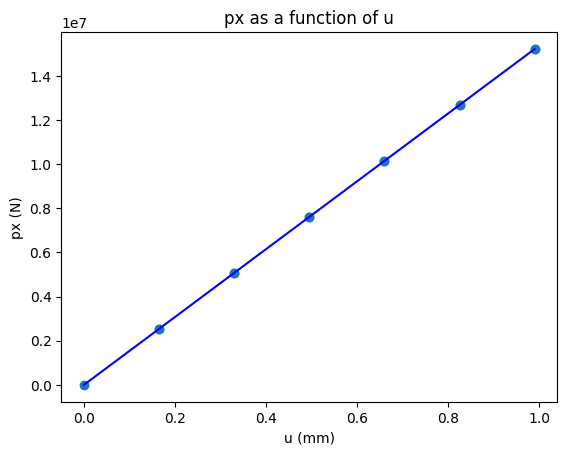

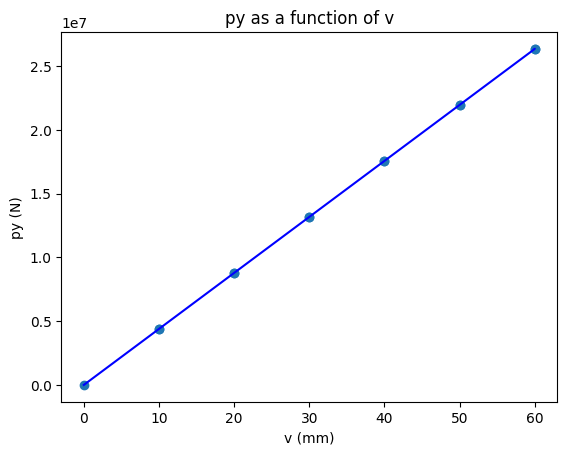

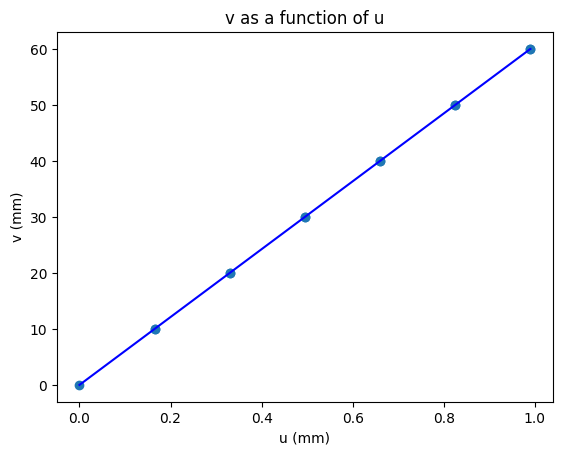

[1, 1]


In [40]:
L,T,Fy = lengths_rotmat_and_Fy()

k,k_glob = stiffness_matrices(T,L)

tol = P / 1e6

lambda_ = 0

step = 0

all_lambdas_archives = []

all_lambdas_points = []

lambdas_archives = []

disp = np.zeros((2,1))

displacement_points = []

bm = np.zeros((2,1))
bm[1] = 1

Pr = np.zeros((nelements,1))

uy = u_y(sigmay, L, E)

print(uy)

while disp[1] < disp_max:

    step += 1

    lambda_it = 0
    disp_it = np.zeros((2,1))
    R_it = np.zeros((2,1))
    
    for j in range(iter_lim):

        # print("Start of iteration", j+1, "step", step)

        if j == 0:
            disp_it[1] = disp_incr
        else:
            disp_it[1] = 0

        # Tangent stiffness calculation

        # Yield?

        ''' Il faut que je code le axial force pour pouvoir comparer avec Fy'''

        # #print("lambda = ", lambda_, "Pr = ", Pr)

        # Py_red = lambda_ * Pr

        # #print("Py_red", Py_red)

        # u_vec,F = u_vec_and_F(Py_red,K_global)

        # print("u_vec = ", u_vec)

        # # Yileding check

        # pelemindex = -1

        # for i in range(nelements):
        #     if u_vec[i] > uy[i]:
        #         print("WSHHHHH")
        #         pelemindex = i
        #         Fy[i] = 0
        
        # if pelemindex != -1:
        #     print("WOOOOOOW")
        #     plastifiedelem.append(pelemindex)
        #     lambdatemp.append(lambdait)
        #     alphaelem[pelemindex] = alpha

        # Assemble elements

        k,k_glob = stiffness_matrices(T, L)

        K_global, K_globals = assemble(alphaelem, k_glob) # Tangent stiffness

        #Reduction of the global matrix

        indexssup = 2*nodes_P - 1
        indexsinf = indexssup - 1
        mask = []
        for i in range(numnodesP):
            mask.append(indexsinf[i])
            mask.append(indexssup[i])
        K_red = K_global[mask,:]
        K_red = K_red[:,mask]

        # Delta load factor and delta displacement in other direction computations

        K_T_inv = np.linalg.inv(K_red)

        lambda_it = (-bm.T @ K_T_inv @ R_it + bm.T @ disp_it)[0] / (bm.T @ K_T_inv @ Pglob)[0]

        # print("lambda_it =", lambda_it)

        disp_it = K_T_inv @ (np.add(lambda_it[0] * Pglob, R_it.T)).T

        # Total load factor and displacement for iteration 

        lambda_ = lambda_ + lambda_it

        # print("LAMBDA_IT = ", lambda_it)
        # print("LAMBDA = ", lambda_)

        all_lambdas_archives.append(lambda_[0])

        # print("lambda = ", lambda_)

        if step == 1 and j==0:
            # print(step,j)
            all_lambdas_points.append(all_lambdas_archives[-1])
        else:
            # print("TEST:", all_lambdas_points[-1], all_lambdas_archives[-1])
            # print(all_lambdas_archives)
            # print(all_lambdas_points)
            all_lambdas_points.append(all_lambdas_points[-1] + all_lambdas_archives[-1])
        
        disp = np.add(disp, disp_it)

        # print("DISP IT = ", disp_it)
        # print("DISP = ", disp)

        displacement_points.append(disp)

        #External applied load

        Pn = lambda_ * Pglob

        #Internal resistance force

        Pr = K_T_inv @ disp

        # print("Pr = ", Pr, "Pn = ", Pn.T)

        #Residual forces

        R_it = Pn.reshape(2,1) - Pr


        if np.linalg.norm(R_it) < tol:
            lambdas_archives.append(lambda_[0])
            break



print(all_lambdas_archives)
print(all_lambdas_points)

all_load_points = []

for i in range(len(all_lambdas_points)):
    all_load_points.append(all_lambdas_points[i] * Pglob)

    px.append(all_load_points[i][0])
    py.append(all_load_points[i][1])

print(all_load_points)

for i in range(len(displacement_points)):
    ui = displacement_points[i][0]
    ui = ui.item()
    vi = displacement_points[i][1]
    vi = vi.item()
    u.append(ui)
    v.append(vi)

printgraph(u,px,"u","px","mm","N")
printgraph(v,py,"v","py","mm","N")
printgraph(u,v,"u","v","mm","mm")

print(alphaelem)



In [36]:
#     # Calculate axial forces

#     axialF = axialforces_withload(Pr,T)

#     print(f"axialF = {axialF}")

#     pelemindex = -1
#     for i in range(nelements):
#         if abs(axialF[i]) > Fy[i] and abs(Fy[i]/axialF[i]) < lambdait and Fy[i] != 0:
#             pelemindex = i
#             Fy[i] = 0
    
#     if pelemindex != -1:
#         plastifiedelem.append(pelemindex)
#         lambdatemp.append(lambdait)
#         alphaelem[pelemindex] = alpha

#     # print(plastifiedelem)
#     # print(f"lambdas = {lambdatemp}")

#     Pcpi = lambdait * Pglobit
#     print(f"Pcpi = {Pcpi}")
#     Pcp.append(Pcpi)


#     #System equilibrium with plastification load for iteration

#     Plastit = [0,0]
#     if len(Pcp) > 0:
#         for i in range(len(Pcp)):
#             Plastit = Pcp[-1] 


#     u_vec,F = u_vec_and_F(Plastit,K_global)

#     print(u_vec)

#     # Calculate axial forces with plasitification load

#     axialFprev = axialforces(K_globals,u_vec,T)
    
#     u,v,px,py,p = points_archives(u,v,px,py,p)

#     print("New iteration", "\n")



# # Final slope

# final_load = Pcp[-1]*2 # Relevant load step in order to observe the behavior after plastification of the entire truss
# print(final_load)

# K_global,K_globals = assemble(alphaelem)

# #System equilibrium with final load

# u_vec,F = u_vec_and_F(final_load,K_global)

# u,v,px,py,p = points_archives(u,v,px,py,p)

# displacementpoints = []
# for i in range(len(plastifiedelem)+2):
#     displacementpoints.append([u[i],v[i]])

# print(f"Displacements for every events [u,v]: {displacementpoints}")
    
    